In [73]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import torch
from torch import nn

torch.set_float32_matmul_precision("medium")  # Try "high" as well

import segmentation_models_pytorch as smp

import sys

try:
    import src
except:
    sys.path.append('../')
    import src

from src.model import WallModel
from src import config
from src.transform import get_train_augmentations

import coremltools as ct
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [4]:
CHECKPOINT_PATH = './epoch=183-train_loss=0.0513-val_loss=0.0699-train_dataset_iou=0.8444-val_dataset_iou=0.8164.ckpt'

model = WallModel.load_from_checkpoint(CHECKPOINT_PATH, init_datasets=False).cpu().eval()

In [5]:
def count_model_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
def reparameterize_model(model):
    return smp.encoders.mobileone.reparameterize_model(model).eval()

In [8]:
num_params_before_reparameterization = count_model_parameters(model)

model_reparameterized = reparameterize_model(model)

num_params_after_reparameterization = count_model_parameters(model_reparameterized)

In [18]:
print('Number of parameters')
print(f'Before reparameterization: {num_params_before_reparameterization}')
print(f'After reparameterization: {num_params_after_reparameterization}')
diff_percentage = float(num_params_after_reparameterization) / float(num_params_before_reparameterization)
print(f'Reparameterized model is {diff_percentage:.2%} size of the original')

Number of parameters
Before reparameterization: 11285009
After reparameterization: 3163409
Reparameterized model is 28.03% size of the original


In [51]:
class WrappedWallModel(nn.Module):

    def __init__(self, model: nn.Module):
        super(WrappedWallModel, self).__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x) # NCHW: (batch_size, 1, height, width)
        # Apply sigmoid to logits to get actual class
        out = out.sigmoid()
        # Remove batch and label dimensions
        out = out.squeeze()
        return out

In [56]:
model_wrapped = WrappedWallModel(model_reparameterized.model)

In [57]:
sample_input = torch.rand((1, 3, config.INPUT_IMAGE_SIZE[1], config.INPUT_IMAGE_SIZE[0])) # NCHW
print(f'Sample input shape: {sample_input.shape}')

Sample input shape: torch.Size([1, 3, 800, 800])


In [58]:
encoder_params = smp.encoders.get_preprocessing_params(config.ENCODER)
print(f'{config.ENCODER} encoder params: {encoder_params}')

mobileone_s3 encoder params: {'input_space': 'RGB', 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}


In [59]:
with torch.no_grad():
    sample_output = model_wrapped(sample_input)
print(f'Sample output shape: {sample_output.shape}')

Sample output shape: torch.Size([800, 800])


In [67]:
trace = torch.jit.trace(model_wrapped, sample_input)

In [102]:
# CoreML preprocessing equation: normalized = data * scale + bias
# y_red_channel = x_red_channel * scale + red_bias
# y_green_channel = x_green_channel * scale + green_bias
# y_blue_channel = x_blue_channel * scale + blue_bias
# 0.226 = (0.229 + 0.224 + 0.225)/3
# We could, however, add this scaling manually by editing model spec directly,
# as descrbed in "Core ML Survival Guide" on pages 271-275
# scale = 1 / (0.226 * 255.0)
scale = 1 / (np.mean(encoder_params['std']) * 255.0)
# bias = [- 0.485 / (0.229), - 0.456 / (0.224), - 0.406 / (0.225)]
bias = [
    - encoder_params['mean'][0] / encoder_params['std'][0],
    - encoder_params['mean'][1] / encoder_params['std'][1],
    - encoder_params['mean'][2] / encoder_params['std'][2],
]

image_input = ct.ImageType(
    name="input",
    shape=sample_input.shape,
    color_layout=ct.colorlayout.RGB,
    scale=scale,
    bias=bias
)

mlmodel = ct.convert(
    trace,
    inputs=[image_input],
    # convert_to="mlprogram",
    # minimum_deployment_target=ct.target.iOS16,
    # compute_precision=ct.precision.FLOAT16
)

Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Converting PyTorch Frontend ==> MIL Ops: 100%|▉| 390/391 [00:00<00:00, 5572.06 o
Running MIL frontend_pytorch pipeline: 100%|█| 5/5 [00:00<00:00, 463.79 passes/s
Running MIL default pipeline: 100%|███████| 56/56 [00:00<00:00, 242.89 passes/s]
Running MIL backend_neuralnetwork pipeline: 100%|█| 8/8 [00:00<00:00, 1207.12 pa
Translating MIL ==> NeuralNetwork Ops: 100%|█| 482/482 [00:00<00:00, 576.04 ops/


### Sample Inference

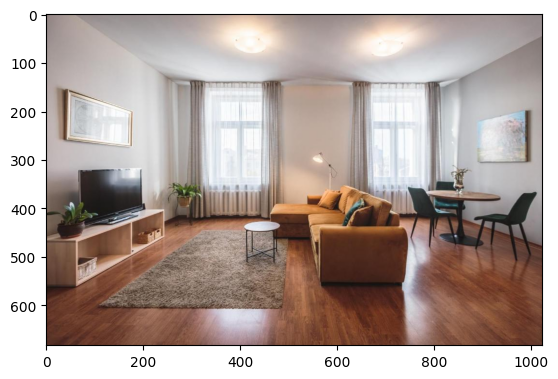

In [72]:
sample_image_path = './apartments.jpeg'
image = PIL.Image.open(sample_image_path)
plt.imshow(image);

(683, 1024, 3)

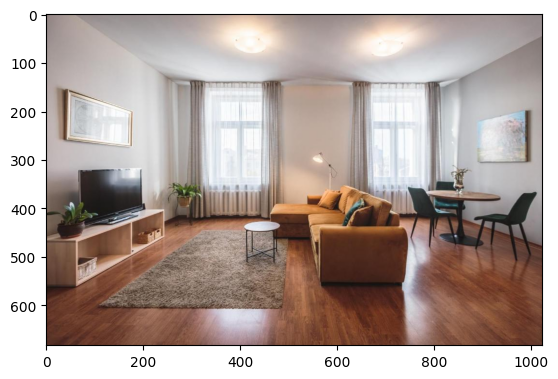

In [80]:
image = np.asarray(image)
plt.imshow(image);
image.shape

(800, 800, 3)

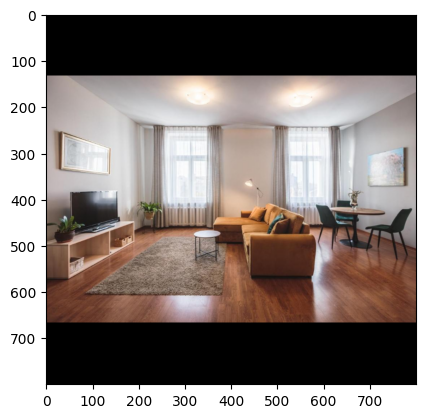

In [84]:
image_preprocessed = get_train_augmentations(augment=False)(image=image)['image']
plt.imshow(image_preprocessed)
image_preprocessed.shape

In [86]:
spec = mlmodel.get_spec()

In [90]:
img_width = spec.description.input[0].type.imageType.width
img_height = spec.description.input[0].type.imageType.height
img_width, img_height

(800, 800)

In [91]:
input_name = spec.description.input[0].name
input_name

'input'

In [92]:
y = mlmodel.predict({input_name: image_preprocessed})

Exception: Model prediction is only supported on macOS version 10.13 or later.

In [103]:
# Set metadata
mlmodel.short_description = 'Wall segmentation model'
mlmodel.input_description['input'] = 'Input RGB image'

output = mlmodel._spec.description.output[0]
output.type.multiArrayType.shape.append(config.INPUT_IMAGE_SIZE[1])
output.type.multiArrayType.shape.append(config.INPUT_IMAGE_SIZE[0])

ct.utils.rename_feature(
    mlmodel._spec, 
    mlmodel.get_spec().description.output[0].name, 
    "output", 
    rename_inputs=True
)

mlmodel.output_description['output'] = "Wall segmentation map"

In [104]:
model_filename = f'{config.ARCHITECTURE}-{config.ENCODER}.mlpackage'
mlmodel.save(model_filename)
print(f'MLModel saved to {model_filename}')

MLModel saved to DeepLabV3Plus-mobileone_s3.mlpackage


In [105]:
!zip -r ./DeepLabV3Plus-mobileone_s3.mlpackage.zip ./DeepLabV3Plus-mobileone_s3.mlpackage

  adding: DeepLabV3Plus-mobileone_s3.mlpackage/ (stored 0%)
  adding: DeepLabV3Plus-mobileone_s3.mlpackage/Manifest.json (deflated 48%)
  adding: DeepLabV3Plus-mobileone_s3.mlpackage/Data/ (stored 0%)
  adding: DeepLabV3Plus-mobileone_s3.mlpackage/Data/com.apple.CoreML/ (stored 0%)
  adding: DeepLabV3Plus-mobileone_s3.mlpackage/Data/com.apple.CoreML/model.mlmodel (deflated 7%)


In [48]:
output.sigmoid().squeeze().shape

torch.Size([800, 800])